# Model using SBERT

Methodologies:
- For each sentence, we feed it into SBERT to get 384-dimensional embedding vector
- We then do dimensionality reduction to get lower dimensional vectors since a too high dimension will cause overfitting
- For each character, we average the latent sentence embeddings to give us a character representation
- We pass this character embedding to predictor to get moral ratings

We will do 4 method variations:
1. PCA with Ridge
2. PCA with MLP
3. AE with Ridge
4. AE with MLP

In [3]:
import json
import os
import sys
import numpy as np
import pandas as pd

In [4]:
with open("..//data//sbert_embedding_structured_data.json", "r") as f:
    sbert_embedding_structured_data = json.load(f)

with open("..//data//structured_data_full.json", "r") as f:
    structured_data_full = json.load(f)

In [5]:
structured_data_full["Superbad"]["SETH"].keys()

dict_keys(['moral', 'non_moral', 'action', 'adj', 'rating'])

### Morally Relevant Traits (from your list)
14 : ["cunning", "honorable"]

22 : ["ferocious", "pacifist"]

25 : ["forgiving", "vengeful"]

28 : ["loyal", "traitorous"]

31 : ["rude", "respectful"]

38 : ["arrogant", "humble"]

39 : ["heroic", "villainous"]

42 : ["mischievous", "well behaved"]

62 : ["confident", "insecure"] – partially relevant (in moral courage contexts)

79 : ["selfish", "altruistic"]

81 : ["angelic", "demonic"] – symbolic moral polarities

84 : ["cruel", "kind"]

85 : ["direct", "roundabout"] – mild moral implication in honesty

101 : ["biased", "impartial"]

121 : ["sarcastic", "genuine"] – relevant to authenticity/honesty

154 : ["judgemental", "accepting"]

195 : ["complimentary", "insulting"]

222 : ["wholesome", "salacious"]

224 : ["zany", "regular"] – possibly borderline, depending on interpretation

227 : ["racist", "egalitarian"]

390 : ["transparent", "machiavellian"]

396 : ["innocent", "jaded"] – tied to moral outlook

425 : ["flawed", "perfect"] – moral implications depending on humility

434 : ["resentful", "euphoric"] – resentment can imply moral judgment

441 : ["buffoon", "charmer"] – charmer can imply moral manipulation

448 : ["fake", "real"] – relevant to honesty

450 : ["catty", "supportive"]

453 : ["eager", "reluctant"] – potentially morally relevant in helping others

464 : ["forward", "repressed"] – honesty and openness in moral contexts

485 : ["maverick", "conformist"] – moral implications in resisting unethical norms

487 : ["social chameleon", "strong identity"] – integrity

489 : ["sincere", "irreverent"]

494 : ["hopeful", "fearful"] – moral optimism vs. nihilism

495 : ["likes change", "resists change"] – in ethical progressivism

497 : ["old-fashioned", "progressive"] – depends on moral norms vs. change



In [12]:
trait_index_to_name = {
    14: "cunning–honorable",
    22: "ferocious–pacifist",
    25: "forgiving–vengeful",
    28: "loyal–traitorous",
    31: "rude–respectful",
    38: "arrogant–humble",
    39: "heroic–villainous",
    42: "mischievous–well-behaved",
    62: "confident–insecure",
    64: "debased–purity",  # we added this trait
    79: "selfish–altruistic",
    81: "angelic–demonic",
    84: "cruel–kind",
    85: "direct–roundabout",
    101: "biased–impartial",
    121: "sarcastic–genuine",
    134: "obedient–rebellious",   # we added this trait
    154: "judgemental–accepting",
    195: "complimentary–insulting",
    222: "wholesome–salacious",
    # 224: "zany–regular",
    227: "racist–egalitarian",
    390: "transparent–machiavellian",
    396: "innocent–jaded",
    # 425: "flawed–perfect",
    434: "resentful–euphoric",
    441: "buffoon–charmer",   # buffoon is a synonym for clown
    448: "fake–real",
    450: "catty–supportive",
    453: "eager–reluctant",
    464: "forward–repressed",
    485: "maverick–conformist",
    # 487: "social chameleon–strong identity",   # social chameleon is a person who changes their behavior to fit in with different social groups
    489: "sincere–irreverent",
    # 494: "hopeful–fearful",
    # 495: "likes change–resists change",
    # 497: "old-fashioned–progressive"
}

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from tqdm import tqdm

# Configuration
latent_dim = 20
reduction_method = "pca"   # or "ae"
model_type = "ridge"       # or "mlp"

# selected_indices = [trait_index_dict[t] for t in selected_traits]
moral_trait_indices = [
    14, 22, 25, 28, 31, 38, 39, 42, 62, 64, 79, 81, 84, 85, 101, 121, 134, 154,
    195, 222, 227, 390, 396, 434, 441, 448, 450, 453,
    464, 485, 489
]


sentence_types = ["moral", "non_moral", "action", "adj"]


In [16]:
def run_moral_trait_prediction(
    sbert_embedding_structured_data,
    structured_data_full,
    trait_index_to_name,
    moral_trait_indices,
    sentence_types=["moral", "non_moral", "action", "adj"],
    reduction_method="pca",
    model_type="ridge",
    latent_dim=20,
    ae_epochs=100
):
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.linear_model import Ridge
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import r2_score, mean_squared_error
    import torch
    import torch.nn as nn
    from tqdm import tqdm
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    print("📦 Collecting all sentence embeddings...")
    all_embeddings = []
    for movie in sbert_embedding_structured_data:
        for char in sbert_embedding_structured_data[movie]:
            for t in sentence_types:
                all_embeddings.extend(sbert_embedding_structured_data[movie][char].get(t, []))
    all_embeddings = np.array(all_embeddings)

    print(f"🔧 Training {reduction_method.upper()} reducer...")
    if reduction_method == "pca":
        reducer = PCA(n_components=latent_dim)
        reducer.fit(all_embeddings)
        reduce_fn = lambda X: reducer.transform(X)
    elif reduction_method == "ae":
        class AE(nn.Module):
            def __init__(self, input_dim=384, latent_dim=latent_dim):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Linear(input_dim, 128),
                    nn.ReLU(),
                    nn.Linear(128, latent_dim)
                )
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, 128),
                    nn.ReLU(),
                    nn.Linear(128, input_dim)
                )

            def forward(self, x):
                z = self.encoder(x)
                return z, self.decoder(z)

        # ae = AE().cuda()
        ae = AE()
        optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
        loss_fn = torch.nn.MSELoss()
        # X_tensor = torch.tensor(all_embeddings, dtype=torch.float32).cuda()
        X_tensor = torch.tensor(all_embeddings, dtype=torch.float32)

        for epoch in range(ae_epochs):
            ae.train()
            z, recon = ae(X_tensor)
            loss = loss_fn(recon, X_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ae.eval()
        # reduce_fn = lambda X: ae.encoder(torch.tensor(X, dtype=torch.float32).cuda()).detach().cpu().numpy()
        reduce_fn = lambda X: ae.encoder(torch.tensor(X, dtype=torch.float32)).detach().cpu().numpy()
    else:
        raise ValueError("Reduction method must be 'pca' or 'ae'.")

    print("Building feature matrix...")
    X, y = [], []
    for movie, chars in sbert_embedding_structured_data.items():
        for char, data in chars.items():
            all_sentences = []
            for t in sentence_types:
                all_sentences.extend(data.get(t, []))

            if not all_sentences:
                continue

            reduced = reduce_fn(np.vstack(all_sentences))
            avg_vector = reduced.mean(axis=0)
            X.append(avg_vector)

            if "rating" in structured_data_full[movie][char] and len(structured_data_full[movie][char]["rating"]) >= max(moral_trait_indices) + 1:
                y.append([structured_data_full[movie][char]["rating"][i] for i in moral_trait_indices])

    X = np.array(X)
    y = np.array(y)
    print(f"Final shape: X = {X.shape}, y = {y.shape}")

    print(f"Training {model_type.upper()} model...")
    if model_type == "ridge":
        model = Ridge()
    elif model_type == "mlp":
        mlp_model = MLPRegressor(
            hidden_layer_sizes=(32, ),
            max_iter=2000,
            early_stopping=True,
            learning_rate='adaptive',
            random_state=42,
            alpha=0.01
        )

        model = make_pipeline(StandardScaler(), mlp_model)  # scale features
    else:
        raise ValueError("Invalid model type.")

    model.fit(X, y)
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))

    print("\n Moral Trait Prediction Results:")
    results = {}
    for i, trait_idx in enumerate(moral_trait_indices):
        trait_name = trait_index_to_name.get(trait_idx, f"Trait {trait_idx}")
        print(f"{trait_name:<35} | R² = {r2[i]:.3f} | RMSE = {rmse[i]:.3f}")
        results[trait_name] = {"R2": r2[i], "RMSE": rmse[i]}
    return results


In [17]:
import pandas as pd

def evaluate_all_models_and_save(
    sbert_embedding_structured_data,
    structured_data_full,
    trait_index_to_name,
    moral_trait_indices,
    filename="..//results//model_1_moral_trait_evaluation.xlsx"
):
    results_dict = {}

    for reduction_method in ["pca", "ae"]:
        for model_type in ["ridge", "mlp"]:
            key = f"{reduction_method.upper()} + {model_type.upper()}"
            print(f"\nRunning: {key}")
            result = run_moral_trait_prediction(
                sbert_embedding_structured_data,
                structured_data_full,
                trait_index_to_name,
                moral_trait_indices,
                reduction_method=reduction_method,
                model_type=model_type
            )
            for trait_name in result:
                if trait_name not in results_dict:
                    results_dict[trait_name] = {}
                results_dict[trait_name][f"{key} R²"] = result[trait_name]["R2"]
                results_dict[trait_name][f"{key} RMSE"] = result[trait_name]["RMSE"]

    # Convert to DataFrame and save to Excel
    df = pd.DataFrame.from_dict(results_dict, orient="index")
    df.to_excel(filename)
    print(f"\n Results saved to {filename}")


In [18]:
evaluate_all_models_and_save(
    sbert_embedding_structured_data,
    structured_data_full,
    trait_index_to_name,
    moral_trait_indices,
    filename="..//results//model_1_moral_trait_evaluation.xlsx"
)


Running: PCA + RIDGE
📦 Collecting all sentence embeddings...
🔧 Training PCA reducer...
Building feature matrix...
Final shape: X = (201, 20), y = (201, 31)
Training RIDGE model...

 Moral Trait Prediction Results:
cunning–honorable                   | R² = 0.063 | RMSE = 20.754
ferocious–pacifist                  | R² = 0.072 | RMSE = 20.534
forgiving–vengeful                  | R² = 0.072 | RMSE = 16.748
loyal–traitorous                    | R² = 0.034 | RMSE = 18.663
rude–respectful                     | R² = 0.065 | RMSE = 15.211
arrogant–humble                     | R² = 0.053 | RMSE = 21.587
heroic–villainous                   | R² = 0.082 | RMSE = 17.197
mischievous–well-behaved            | R² = 0.049 | RMSE = 14.070
confident–insecure                  | R² = 0.041 | RMSE = 18.108
debased–purity                      | R² = 0.042 | RMSE = 16.103
selfish–altruistic                  | R² = 0.027 | RMSE = 12.912
angelic–demonic                     | R² = 0.100 | RMSE = 18.465
cruel

## Results Analysis

In [23]:
model_1_result = pd.read_excel("..//results//model_1_moral_trait_evaluation.xlsx", index_col=0)
baseline_2_result = pd.read_excel("..//results//baseline_2_moral_trait_evaluation.xlsx", index_col=0)

Let's check the top 5 and bottom 5 traits based on R-squared in the result of Model 1

Top 5: ['direct–roundabout', 'angelic–demonic', 'heroic–villainous', 'sincere–irreverent', 'obedient–rebellious']
Bottom 5: ['selfish–altruistic', 'fake–real', 'eager–reluctant', 'loyal–traitorous', 'catty–supportive']


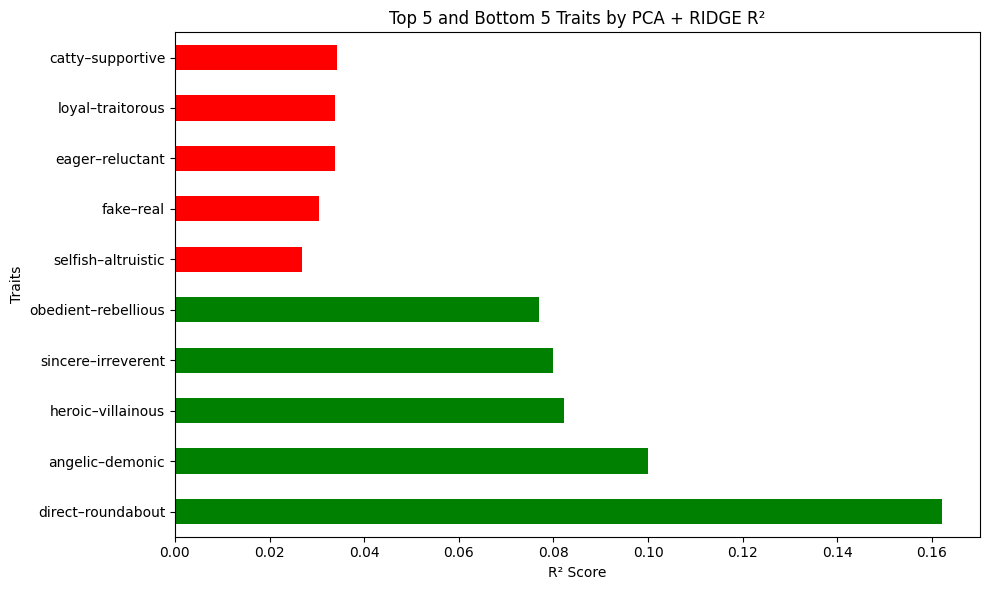

In [20]:
model_1_result.iloc[0, 0]
top_5 = model_1_result.nlargest(5, "PCA + RIDGE R²").index.tolist()
bottom_5 = model_1_result.nsmallest(5, "PCA + RIDGE R²").index.tolist()
print("Top 5:", top_5)
print("Bottom 5:", bottom_5)
import matplotlib.pyplot as plt

# Plot top 5 and bottom 5 traits horizontally
traits = top_5 + bottom_5
scores = model_1_result.loc[traits, "PCA + RIDGE R²"]

plt.figure(figsize=(10, 6))
scores.plot(kind='barh', color=['green'] * 5 + ['red'] * 5)
plt.title("Top 5 and Bottom 5 Traits by PCA + RIDGE R²")
plt.xlabel("R² Score")
plt.ylabel("Traits")
plt.tight_layout()
plt.show()


Let's check the top 5 and bottom 5 traits based on R-squared in the result of Baseline 2

Top 5: ['angelic–demonic', 'forward–repressed', 'transparent–machiavellian', 'cruel–kind', 'confident–insecure']
Bottom 5: ['loyal–traitorous', 'maverick–conformist', 'selfish–altruistic', 'catty–supportive', 'wholesome–salacious']


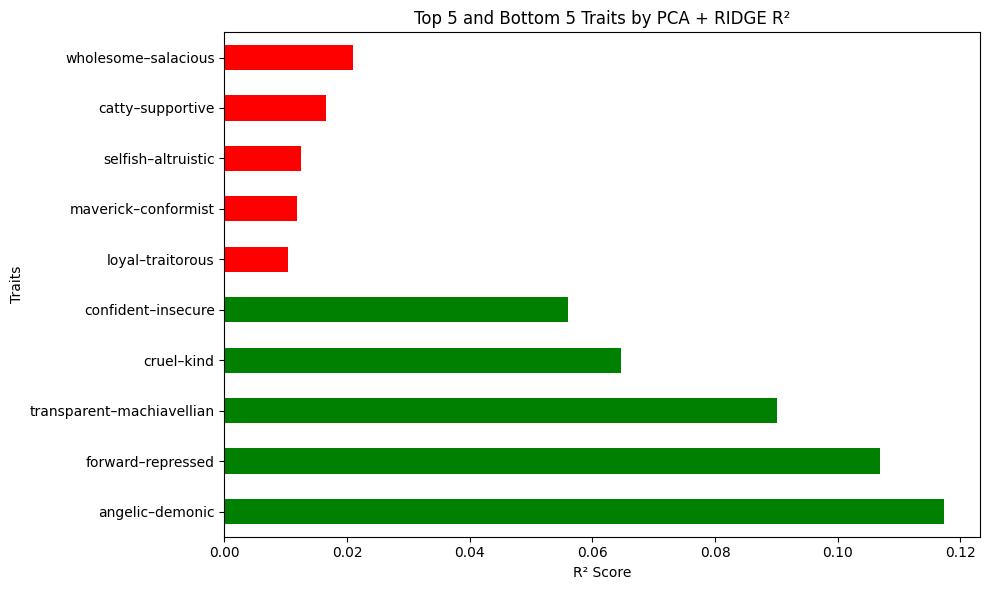

In [24]:
baseline_2_result.iloc[0, 0]
top_5 = baseline_2_result.nlargest(5, "PCA + RIDGE R²").index.tolist()
bottom_5 = baseline_2_result.nsmallest(5, "PCA + RIDGE R²").index.tolist()
print("Top 5:", top_5)
print("Bottom 5:", bottom_5)
import matplotlib.pyplot as plt

# Plot top 5 and bottom 5 traits horizontally
traits = top_5 + bottom_5
scores = baseline_2_result.loc[traits, "PCA + RIDGE R²"]

plt.figure(figsize=(10, 6))
scores.plot(kind='barh', color=['green'] * 5 + ['red'] * 5)
plt.title("Top 5 and Bottom 5 Traits by PCA + RIDGE R²")
plt.xlabel("R² Score")
plt.ylabel("Traits")
plt.tight_layout()
plt.show()


## What does the model predict for iconic characters?



In [30]:
structured_data_full["The Dark Knight"].keys()

# 'Star Wars: Episode IV - A New Hope' - LUKE
# 'The Shawshank Redemption' - RED
# 'Toy Story' - WOODY
# 'The Dark Knight' - THE JOKER

dict_keys(['THE JOKER', 'GORDON', 'DENT'])

In [33]:
def run_moral_trait_prediction_with_model(
    sbert_embedding_structured_data,
    structured_data_full,
    trait_index_to_name,
    moral_trait_indices,
    sentence_types=["moral", "non_moral", "action", "adj"],
    reduction_method="pca",
    model_type="ridge",
    latent_dim=20,
    ae_epochs=100
):
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.linear_model import Ridge
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import r2_score, mean_squared_error
    import torch
    import torch.nn as nn
    from tqdm import tqdm
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    print("📦 Collecting all sentence embeddings...")
    all_embeddings = []
    for movie in sbert_embedding_structured_data:
        for char in sbert_embedding_structured_data[movie]:
            for t in sentence_types:
                all_embeddings.extend(sbert_embedding_structured_data[movie][char].get(t, []))
    all_embeddings = np.array(all_embeddings)

    print(f"🔧 Training {reduction_method.upper()} reducer...")
    if reduction_method == "pca":
        reducer = PCA(n_components=latent_dim)
        reducer.fit(all_embeddings)
        reduce_fn = lambda X: reducer.transform(X)
    elif reduction_method == "ae":
        class AE(nn.Module):
            def __init__(self, input_dim=384, latent_dim=latent_dim):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Linear(input_dim, 128),
                    nn.ReLU(),
                    nn.Linear(128, latent_dim)
                )
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, 128),
                    nn.ReLU(),
                    nn.Linear(128, input_dim)
                )

            def forward(self, x):
                z = self.encoder(x)
                return z, self.decoder(z)

        ae = AE()
        optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
        loss_fn = torch.nn.MSELoss()
        X_tensor = torch.tensor(all_embeddings, dtype=torch.float32)
        for epoch in range(ae_epochs):
            ae.train()
            z, recon = ae(X_tensor)
            loss = loss_fn(recon, X_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        ae.eval()
        reduce_fn = lambda X: ae.encoder(torch.tensor(X, dtype=torch.float32)).detach().cpu().numpy()
    else:
        raise ValueError("Invalid reducer.")

    print("Building feature matrix...")
    X, y, movie_char_pairs = [], [], []
    for movie, chars in sbert_embedding_structured_data.items():
        for char, data in chars.items():
            all_sentences = []
            for t in sentence_types:
                all_sentences.extend(data.get(t, []))
            if not all_sentences:
                continue
            reduced = reduce_fn(np.vstack(all_sentences))
            avg_vector = reduced.mean(axis=0)
            X.append(avg_vector)
            movie_char_pairs.append((movie, char))
            if "rating" in structured_data_full[movie][char] and len(structured_data_full[movie][char]["rating"]) >= max(moral_trait_indices) + 1:
                y.append([structured_data_full[movie][char]["rating"][i] for i in moral_trait_indices])

    X = np.array(X)
    y = np.array(y)

    print(f"Training {model_type.upper()} model...")
    if model_type == "ridge":
        model = Ridge()
    elif model_type == "mlp":
        mlp_model = MLPRegressor(
            hidden_layer_sizes=(32,),
            max_iter=2000,
            early_stopping=True,
            learning_rate='adaptive',
            random_state=42,
            alpha=0.01
        )
        model = make_pipeline(StandardScaler(), mlp_model)
    else:
        raise ValueError("Invalid model type.")

    model.fit(X, y)
    return model, reduce_fn, movie_char_pairs


In [31]:
# Re-defining the function since kernel was reset
def extract_selected_character_predictions(
    sbert_embedding_structured_data,
    structured_data_full,
    trait_index_to_name,
    moral_trait_indices,
    model,
    reduce_fn,
    sentence_types=["moral", "non_moral", "action", "adj"],
    selected_characters=None
):
    result_rows = []

    for movie, chars in sbert_embedding_structured_data.items():
        for char, data in chars.items():
            if selected_characters and (movie not in selected_characters or char not in selected_characters[movie]):
                continue

            all_sentences = []
            for t in sentence_types:
                all_sentences.extend(data.get(t, []))

            if not all_sentences:
                continue

            reduced = reduce_fn(np.vstack(all_sentences))
            avg_vector = reduced.mean(axis=0)

            if "rating" not in structured_data_full[movie][char]:
                continue

            char_rating = structured_data_full[movie][char]["rating"]
            if len(char_rating) < max(moral_trait_indices) + 1:
                continue

            true_vector = [char_rating[i] for i in moral_trait_indices]
            pred_vector = model.predict([avg_vector])[0]

            for idx, trait_idx in enumerate(moral_trait_indices):
                trait_name = trait_index_to_name.get(trait_idx, f"Trait {trait_idx}")
                result_rows.append({
                    "Character": f"{movie}_{char}",
                    "Trait": trait_name,
                    "Ground Truth": true_vector[idx],
                    "Predicted Rating": pred_vector[idx]
                })

    selected_results_df = pd.DataFrame(result_rows)
    return selected_results_df

In [35]:
selected_characters = {
    "The Dark Knight": ["THE JOKER"],
    "Toy Story": ["WOODY"],
    "The Shawshank Redemption": ["RED"],
    "Star Wars: Episode IV - A New Hope": ["LUKE"]
}

In [36]:
model, reduce_fn, movie_char_pairs = run_moral_trait_prediction_with_model(
    sbert_embedding_structured_data=sbert_embedding_structured_data,
    structured_data_full=structured_data_full,
    trait_index_to_name=trait_index_to_name,
    moral_trait_indices=moral_trait_indices,
    reduction_method="pca",
    model_type="ridge"
)

df_preds = extract_selected_character_predictions(
    model=model,
    reduce_fn=reduce_fn,
    selected_characters=selected_characters,
    sbert_embedding_structured_data=sbert_embedding_structured_data,
    structured_data_full=structured_data_full,
    trait_index_to_name=trait_index_to_name,
    moral_trait_indices=moral_trait_indices,
    sentence_types=["moral", "non_moral", "action", "adj"]
)


📦 Collecting all sentence embeddings...
🔧 Training PCA reducer...
Building feature matrix...
Training RIDGE model...


In [47]:
joker_result_df = df_preds[df_preds["Character"] == "The Dark Knight_THE JOKER"]
woody_result_df = df_preds[df_preds["Character"] == "Toy Story_WOODY"]
red_result_df = df_preds[df_preds["Character"] == "The Shawshank Redemption_RED"]
luke_result_df = df_preds[df_preds["Character"] == "Star Wars: Episode IV - A New Hope_LUKE"]

joker_result_df = joker_result_df.drop(columns=["Character"])
woody_result_df = woody_result_df.drop(columns=["Character"])
red_result_df = red_result_df.drop(columns=["Character"])
luke_result_df = luke_result_df.drop(columns=["Character"])

In [50]:
joker_result_df.to_excel("..//results//model_1_joker_result.xlsx", index=False)
woody_result_df.to_excel("..//results//model_1_woody_result.xlsx", index=False)
red_result_df.to_excel("..//results//model_1_red_result.xlsx", index=False)
luke_result_df.to_excel("..//results//model_1_luke_result.xlsx", index=False)